In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-04-03 06:03:26--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.6MB/s    in 3.3s    

2023-04-03 06:03:30 (49.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
def load_data(file_location):
    x_train = None
    y_train = None

    # Train data
    for i in [1, 2, 3, 4, 5]:
        db_dict = unpickle(file_location+"data_batch_"+str(i))
        data_points = len(db_dict[b'data'])
        data = db_dict[b'data']\
                  .reshape((data_points, 3, 32, 32))\
                  .transpose((0, 2, 3, 1))
        if x_train is None:
            x_train = data
            y_train = db_dict[b'labels']
        else:
            x_train = np.concatenate((x_train, data))
            y_train = np.concatenate((y_train, db_dict[b'labels']))
    
    # Test data
    db_dict = unpickle(file_location+"test_batch")
    data_points = len(db_dict[b'data'])
    x_test = db_dict[b'data']\
                .reshape((data_points, 3, 32, 32))\
                .transpose((0, 2, 3, 1))
    y_test = np.array(db_dict[b'labels'])
    
    return (x_train, y_train), (x_test, y_test)

In [ ]:
meta_dict = unpickle("./cifar-10-batches-py/batches.meta")
meta_dict[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data("./cifar-10-batches-py/")
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


Label value: 9 and label name: b'truck'


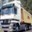

In [ ]:
print("Label value: {0} and label name: {1}".format(y_train[1], meta_dict[b'label_names'][y_train[1]]))
tf.keras.utils.array_to_img(x_train[1])

In [ ]:
if 'COLAB_TPU_ADDR' in os.environ:
  TPU_WORKER = 'grpc://{0}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_WORKER=''
print(TPU_WORKER)

grpc://10.90.216.186:8470


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print(tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

[LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Baseline model

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, steps_per_epoch=200,
                    verbose=2,validation_steps=50,validation_split=0.2)

Epoch 1/50
200/200 - 10s - loss: 2.1541 - sparse_categorical_accuracy: 0.1650 - val_loss: 1.9282 - val_sparse_categorical_accuracy: 0.2319 - 10s/epoch - 48ms/step
Epoch 2/50
200/200 - 3s - loss: 1.8459 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.7078 - val_sparse_categorical_accuracy: 0.3625 - 3s/epoch - 14ms/step
Epoch 3/50
200/200 - 3s - loss: 1.6924 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.5775 - val_sparse_categorical_accuracy: 0.4112 - 3s/epoch - 14ms/step
Epoch 4/50
200/200 - 2s - loss: 1.5689 - sparse_categorical_accuracy: 0.4234 - val_loss: 1.5232 - val_sparse_categorical_accuracy: 0.4256 - 2s/epoch - 12ms/step
Epoch 5/50
200/200 - 3s - loss: 1.4783 - sparse_categorical_accuracy: 0.4456 - val_loss: 1.4046 - val_sparse_categorical_accuracy: 0.4762 - 3s/epoch - 13ms/step
Epoch 6/50
200/200 - 2s - loss: 1.4482 - sparse_categorical_accuracy: 0.4589 - val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.4913 - 2s/epoch - 12ms/step
Epoch 7/50
200/200 - 2s - loss: 

In [ ]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 14ms/step - loss: 1.0031 - sparse_categorical_accuracy: 0.6842


[1.0031206607818604, 0.6841999888420105]

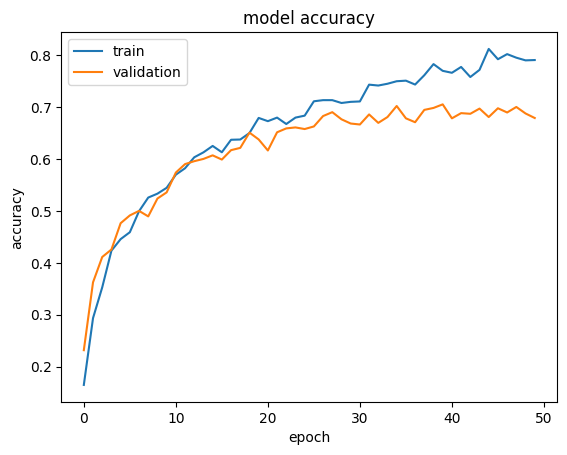

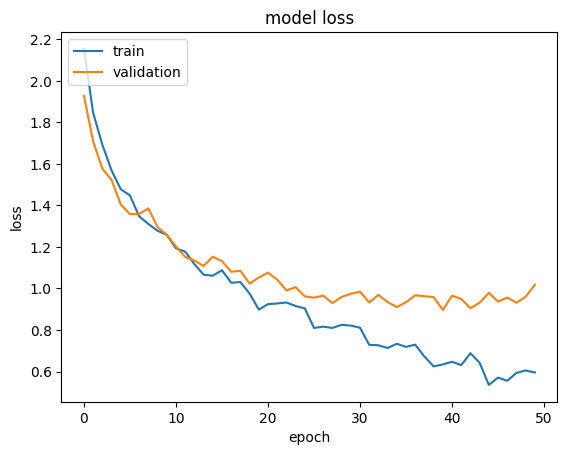

In [ ]:
# Model Accuracy Plot
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.title("Model Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Model Loss Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Baseline model with L2 Regularization

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, steps_per_epoch=200,
                    verbose=2,validation_steps=50,validation_split=0.2)

Epoch 1/50
200/200 - 11s - loss: 11.0928 - sparse_categorical_accuracy: 0.2111 - val_loss: 3.7247 - val_sparse_categorical_accuracy: 0.0919 - 11s/epoch - 54ms/step
Epoch 2/50
200/200 - 3s - loss: 2.5693 - sparse_categorical_accuracy: 0.2866 - val_loss: 2.7011 - val_sparse_categorical_accuracy: 0.0919 - 3s/epoch - 13ms/step
Epoch 3/50
200/200 - 3s - loss: 1.9431 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.9757 - val_sparse_categorical_accuracy: 0.2956 - 3s/epoch - 14ms/step
Epoch 4/50
200/200 - 2s - loss: 1.7998 - sparse_categorical_accuracy: 0.3688 - val_loss: 3.1461 - val_sparse_categorical_accuracy: 0.2100 - 2s/epoch - 11ms/step
Epoch 5/50
200/200 - 2s - loss: 1.7234 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.2119 - val_sparse_categorical_accuracy: 0.3006 - 2s/epoch - 11ms/step
Epoch 6/50
200/200 - 2s - loss: 1.5996 - sparse_categorical_accuracy: 0.4556 - val_loss: 2.1711 - val_sparse_categorical_accuracy: 0.3988 - 2s/epoch - 11ms/step
Epoch 7/50
200/200 - 2s - loss:

In [ ]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 1.0931 - sparse_categorical_accuracy: 0.6668


[1.0930653810501099, 0.6668000221252441]

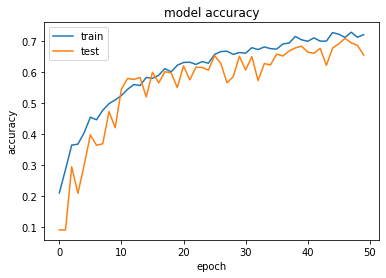

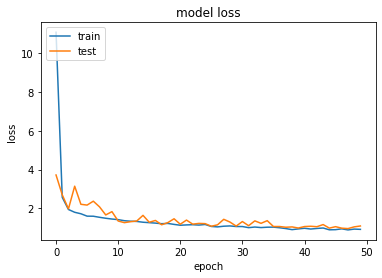

In [ ]:
# plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Baseline model with dropout

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((32, 32, 3)))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, steps_per_epoch=200,
                    verbose=2,validation_steps=50,validation_split=0.2)

Epoch 1/50
200/200 - 10s - loss: 2.2440 - sparse_categorical_accuracy: 0.1402 - val_loss: 2.0143 - val_sparse_categorical_accuracy: 0.2150 - 10s/epoch - 51ms/step
Epoch 2/50
200/200 - 2s - loss: 1.9785 - sparse_categorical_accuracy: 0.2198 - val_loss: 1.8703 - val_sparse_categorical_accuracy: 0.2581 - 2s/epoch - 11ms/step
Epoch 3/50
200/200 - 2s - loss: 1.8593 - sparse_categorical_accuracy: 0.2878 - val_loss: 1.7543 - val_sparse_categorical_accuracy: 0.3338 - 2s/epoch - 12ms/step
Epoch 4/50
200/200 - 3s - loss: 1.7792 - sparse_categorical_accuracy: 0.3162 - val_loss: 1.6913 - val_sparse_categorical_accuracy: 0.3887 - 3s/epoch - 16ms/step
Epoch 5/50
200/200 - 2s - loss: 1.7498 - sparse_categorical_accuracy: 0.3303 - val_loss: 1.6466 - val_sparse_categorical_accuracy: 0.3800 - 2s/epoch - 11ms/step
Epoch 6/50
200/200 - 2s - loss: 1.6763 - sparse_categorical_accuracy: 0.3641 - val_loss: 1.6225 - val_sparse_categorical_accuracy: 0.3950 - 2s/epoch - 11ms/step
Epoch 7/50
200/200 - 2s - loss: 

In [ ]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 13ms/step - loss: 1.0226 - sparse_categorical_accuracy: 0.6458


[1.022599220275879, 0.645799994468689]

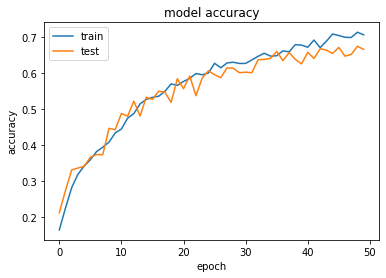

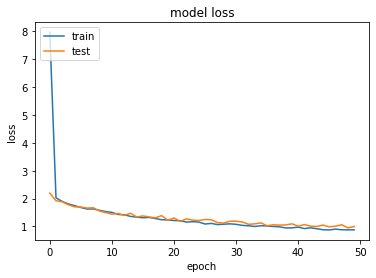

In [ ]:
# plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# VGGNet model

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    base_model_output = tf.keras.applications.vgg16.VGG16(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )(resize)  
       
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    pred = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=pred)
    return model


In [ ]:
model=create_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 1024)              525312    
                                                                 
 dense_28 (Dense)            (None, 512)               5248

In [ ]:
with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, 
                    verbose=2,validation_split=0.2)

Epoch 1/10
625/625 - 69s - loss: 1.4649 - sparse_categorical_accuracy: 0.4791 - val_loss: 1.6797 - val_sparse_categorical_accuracy: 0.4929 - 69s/epoch - 111ms/step
Epoch 2/10
625/625 - 46s - loss: 0.7113 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.6702 - val_sparse_categorical_accuracy: 0.7716 - 46s/epoch - 73ms/step
Epoch 3/10
625/625 - 45s - loss: 0.4813 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.5181 - val_sparse_categorical_accuracy: 0.8207 - 45s/epoch - 73ms/step
Epoch 4/10
625/625 - 46s - loss: 0.3620 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.4794 - val_sparse_categorical_accuracy: 0.8421 - 46s/epoch - 73ms/step
Epoch 5/10
625/625 - 46s - loss: 0.2914 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.3754 - val_sparse_categorical_accuracy: 0.8742 - 46s/epoch - 74ms/step
Epoch 6/10
625/625 - 46s - loss: 0.2299 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.3144 - val_sparse_categorical_accuracy: 0.8984 - 46s/epoch - 73ms/step
Epoch 7/10
625/625 - 

In [ ]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

  47/1563 [..............................] - ETA: 39s - loss: 0.0409 - sparse_categorical_accuracy: 0.9847

KeyboardInterrupt: ignored

In [ ]:
# plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

# ResNet model

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    base_model_output = tf.keras.applications.resnet.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet'
    )(resize)  
       
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
    return model


In [ ]:
model=create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 512)               5248

In [ ]:
with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64, 
                    verbose=2,validation_split=0.2)

Epoch 1/50
625/625 - 96s - loss: 0.6877 - sparse_categorical_accuracy: 0.7712 - val_loss: 3.4576 - val_sparse_categorical_accuracy: 0.1982 - 96s/epoch - 154ms/step
Epoch 2/50
625/625 - 37s - loss: 0.2644 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 0.9208 - 37s/epoch - 59ms/step
Epoch 3/50
625/625 - 36s - loss: 0.1545 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.2001 - val_sparse_categorical_accuracy: 0.9352 - 36s/epoch - 58ms/step
Epoch 4/50
625/625 - 37s - loss: 0.0951 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.1887 - val_sparse_categorical_accuracy: 0.9413 - 37s/epoch - 59ms/step
Epoch 5/50
625/625 - 36s - loss: 0.0600 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9351 - 36s/epoch - 58ms/step
Epoch 6/50
625/625 - 36s - loss: 0.0417 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.2168 - val_sparse_categorical_accuracy: 0.9406 - 36s/epoch - 58ms/step
Epoch 7/50
625/625 - 

In [ ]:
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.2362 - sparse_categorical_accuracy: 0.9527


[0.23619285225868225, 0.9527000188827515]

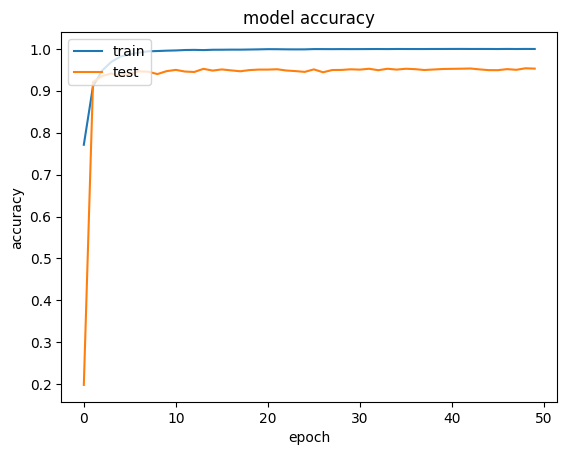

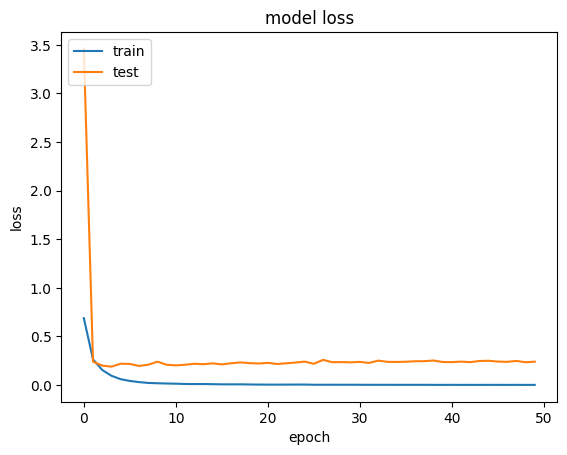

In [ ]:
# plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(32, 32, 3)


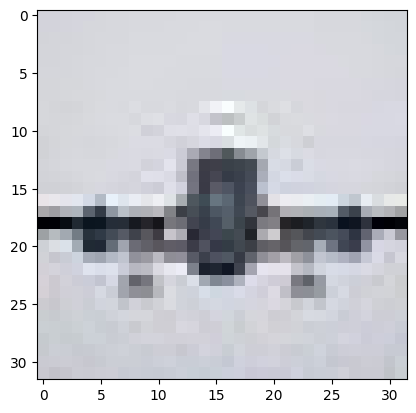

In [ ]:
from PIL import Image
im = Image.open("./test.jpg")
im = np.array(im)
im = im/255.0
print(im.shape)
plt.imshow(im)

In [ ]:
#im = im.reshape(32,32,3)
im_data = list()
for i in range(0,32):
    im_data.append(im)
im_data = np.array(im_data)
im_data.shape

(32, 32, 32, 3)

In [ ]:
im = im.reshape(1,32,32,3)
pred = model.predict(im)

1/1 [==============================] - 2s 2s/step


In [ ]:
pred

array([[0.7640375 , 0.02761129, 0.0605011 , 0.01864172, 0.01357855,
        0.00529757, 0.01267054, 0.00173576, 0.01976069, 0.07616521]],
      dtype=float32)

In [ ]:
np.argmax(pred[0])

0

In [ ]:
meta_dict[b'label_names'][0]

b'airplane'